In [14]:
import numpy as np
if not hasattr(np, 'longfloat'):
    np.longfloat = np.float64
import serpentTools as st
from pathlib import Path
from numpy.linalg import norm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
import openmc

/home/garcsamu/.conda/envs/snap/lib/python3.11/site-packages/openmc/config.py:62: UserWarning: '/home/garcsamu/cross_sections/endfb-viii.0-hdf5/cross_sections.xml' does not exist.
  warnings.warn(f"'{value}' does not exist.")


# Effect of Hydrogen Content on Reactivity

SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.5/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.55/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.
SERPENT Serpent 2.2.1 found in /home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.65/s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to

/home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.5/s82d_ac_c3_gcu_ringres.main_res.m
/home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.55/s82d_ac_c3_gcu_ringres.main_res.m
/home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.65/s82d_ac_c3_gcu_ringres.main_res.m
/home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/Serpent/depletion/hydrogen_dissociation/H_Zr_1.7/s82d_ac_c3_gcu_ringres.main_res.m


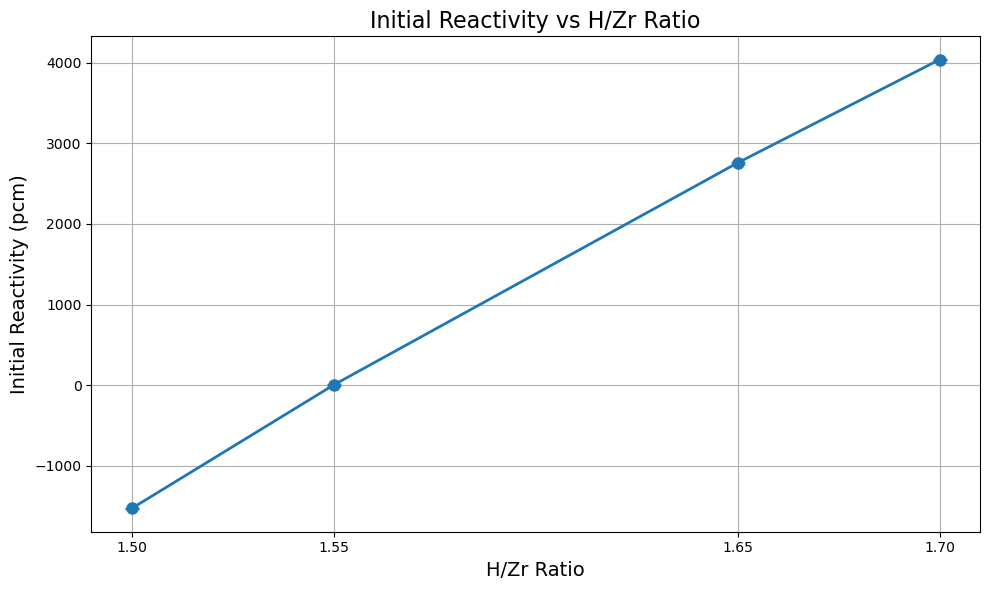

In [15]:
current_dir = Path.cwd()
ratios = ["1.5", "1.55", "1.65", "1.7"]
ratio_values = []
rho_values = []
rho_err_values = []

for ratio in ratios:
    h_zr_dir = f"H_Zr_{ratio}"
    res_rel_path = Path(f"Serpent/depletion/hydrogen_dissociation/{h_zr_dir}/s82d_ac_c3_gcu_ringres.main_res.m")
    res_path = (current_dir/res_rel_path).resolve()
    print(res_path)
    # Check if file exists
    if not res_path.exists():
        print(f"Warning: File not found: {res_path}")
        continue
    
    dep = st.read(res_path)
    # Get k values
    anakeff = dep['impKeff'][0]
    k_err = dep['impKeff'][1]
    
    # Calculate reactivity
    rho = (1 - 1/anakeff) * 10**5  # Convert to pcm
    rho_err = (k_err / anakeff**2) * 10**5  # Convert to pcm
    
    # Store values in arrays
    ratio_values.append(float(ratio))
    rho_values.append(rho)
    rho_err_values.append(rho_err)

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(ratio_values, rho_values, yerr=rho_err_values, 
             fmt='o-', capsize=5, linewidth=2, markersize=8)

plt.xlabel('H/Zr Ratio', fontsize=14)
plt.ylabel('Initial Reactivity (pcm)', fontsize=14)
plt.title('Initial Reactivity vs H/Zr Ratio', fontsize=16)
plt.grid(True)
plt.xticks(ratio_values)
plt.tight_layout()
plt.show()

# Depletion Comparison

SERPENT Serpent 2.2.1 found in C:\Users\Sam\Documents\SNAP-REACTORS-PRIVATE\snapReactors\reactor_models\Wet_Experiment_Models\burned_XS\s82d_ac_c3_gcu_ringres.main_res.m, but version 2.1.31 is defined in settings
  Attempting to read anyway. Please report strange behaviors/failures to developers.


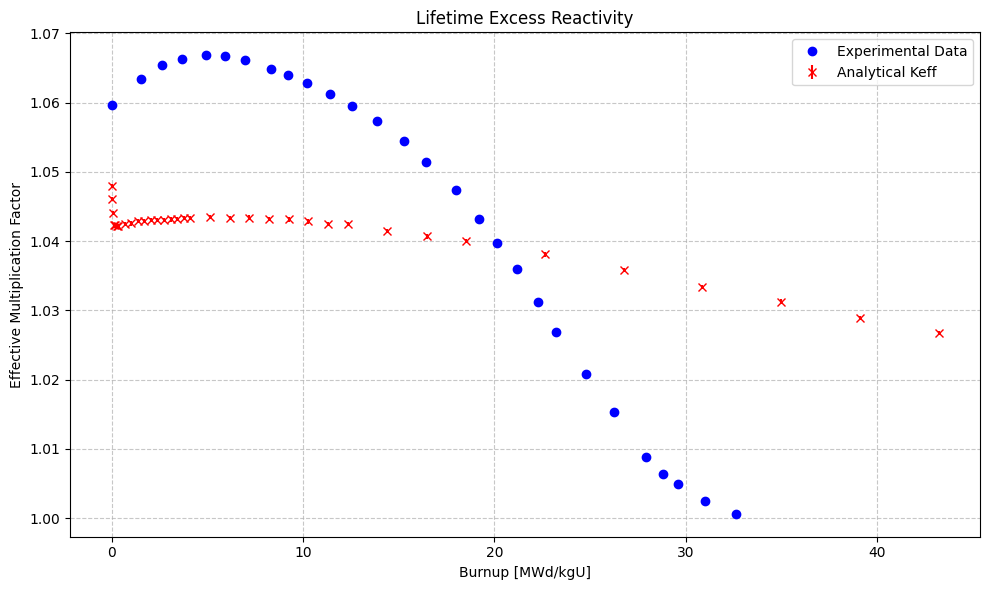

In [ ]:
## OpenMC results
current_dir = Path.cwd()
cardinal_path = 'Serpent/depletion/OpenMC_Res/depletion_results.h5'
cardinal_path = (current_dir/cardinal_path).resolve()
cardRes = openmc.deplete.Results(filename='/home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/burned_XS/OpenMC_Res/depletion_results.h5')
time, keff = cardRes.get_keff(time_units='d')
err_cardkeff = keff[:,1]
k_cardkeff = keff[:,0]
rho_card = (1-1/k_cardkeff)*1e5
rho_unc = 3* np.sqrt((1/k_cardkeff**2)**2 * err_cardkeff**2)*1e5
burn_time = time * 0.600 / 6.56
rho_card_match = 1713.12
print(burn_time)
print(rho_card)
print(rho_unc)
## linearizing hydrogen effects
# 
current_dir = Path.cwd()
burn_rel_path_17 = Path('H_Zr_1.7/s82d_ac_c3_gcu_ringres.main_res.m')
burn_17_path = (current_dir/burn_rel_path_17).resolve()
dep_17 = st.read(burn_17_path)
burnup_17 = st.read('/home/garcsamu/Serpent/SNAP-REACTORS-PRIVATE/snapReactors/reactor_models/Wet_Experiment_Models/burned_XS/H_Zr_1.7/s82d_ac_c3_gcu_ringres.main_dep.m').burnup
anakeff_17 = dep_17['impKeff'][:,0]
rho_17 = np.zeros_like(anakeff_17)
rho_17 = (1 - 1/anakeff_17)*1e5
rho_17_match = rho_17 + 684.2
print(rho_17_match)
hy_loss = 161.91174391612 * burnup_17
rho_17_adjusted = rho_17_match - hy_loss
anakeff_17_err = dep_17['impKeff'][:,1]
rho_17_err = 3* np.sqrt((1/anakeff_17**2)**2 * anakeff_17_err**2)*1e5
rho_17_unadj_err = rho_17_err
exp_rel_path = Path('H_Zr_1.7/burn-data.csv')
exp_path = (current_dir/exp_rel_path).resolve()
exp_data = pd.read_csv(exp_path)
x_data = exp_data['x (MWd/kgU)'].values
y_data = exp_data['y(pcm)'].values

plt.figure(figsize = (10,6))
plt.xlabel("Burnup [MWd/kgU]")
plt.ylabel("Keff")
plt.errorbar(x_data, y_data, yerr=None, fmt='o', label="Experimental Data", color='blue')
plt.errorbar(burnup_17[:-3], rho_17_adjusted[:-3], yerr = rho_17_err[:-3], fmt = 'x', label = 'Serpent Adjusted', color = 'green')
plt.xlabel("Burnup [MWd/kgU]")
plt.ylabel("ρ [pcm]")
# plt.errorbar(burnup_16, anakeff_16, yerr = anakeff_16_err, fmt = 'x', label = 'H/Zr = 1.6', color = 'red')
plt.errorbar(burnup_17[:-3], rho_17[:-3], yerr = rho_17_unadj_err[:-3], fmt = 'x', label = 'Serpent Unadjusted', color = 'red')
plt.errorbar(burn_time, rho_card, yerr = rho_unc, fmt = 'x', label = 'OpenMC', color = 'black')
plt.legend()
plt.grid(True, linestyle = '--', alpha = 0.7)
plt.tight_layout()